In [1]:
import gc
from desom.som_layer import SOMLayer
from desom.autoencoder import conv2d_autoencoder
from desom.datasets import load_data

import tensorflow as tf
from keras.models import Model, Sequential
from keras.metrics import Mean, MeanAbsoluteError

import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import xarray as xr

from plots import *
from Experiment import *

%load_ext autoreload
%autoreload 2

2023-08-04 13:45:05.305939: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-04 13:45:08.257413: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [181]:
from keras.metrics import Mean
from keras.losses import binary_crossentropy
class DESOM(Model):
    def __init__(self, encoder, decoder, som_layer, norm = 1, factors  = None, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.som_layer = som_layer
        if factors is None:
            factors = [1, 1, 1]
        self.factors = factors
        self.total_loss_tracker = Mean(name="total_loss")
        self.reconstruction_loss_tracker = Mean(
            name="reconstruction_loss"
        )
        self.orthogonal_loss_tracker = Mean(name="orthogonal_loss")
        self.som_loss_tracker = Mean(name="som_loss")
        self.norm = norm
        embeddings = self.decoder(tf.eye(self.decoder.input.shape[-1]))
        embeddings = tf.reshape(embeddings, (embeddings.shape[0], -1))
        self.embedding_norm = tf.reduce_mean(tf.linalg.norm(embeddings, axis=1)).numpy()

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.orthogonal_loss_tracker,
            self.som_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z = self.encoder(data)
            som_loss = self.som_layer(z)
            reconstruction = self.decoder(z)
            # reconstruction_loss = tf.reduce_mean(
            #     tf.reduce_mean(
            #         binary_crossentropy(data, reconstruction), axis=(1, 2)
            #     )
            # )
            reconstruction_loss = tf.reduce_mean(
                tf.math.reduce_euclidean_norm(
                    (data - reconstruction) * self.norm, axis=(1, 2, 3)
                )
            )
            embeddings = self.decoder(tf.eye(self.decoder.input.shape[-1]))
            embeddings = tf.reshape(embeddings, (embeddings.shape[0], -1))
            arr = embeddings @ tf.transpose(embeddings)
            orthogonal_loss = tf.reduce_sum(tf.abs(arr - self.embedding_norm * tf.eye(embeddings.shape[0])))
            total_loss = self.factors[0] * reconstruction_loss + self.factors[1] * orthogonal_loss + self.factors[2] * som_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.orthogonal_loss_tracker.update_state(orthogonal_loss)
        self.som_loss_tracker.update_state(som_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "orthogonal_loss": self.orthogonal_loss_tracker.result(),
            "som_loss": self.som_loss_tracker.result(),
        }

In [182]:
# da = xr.open_dataarray('/Users/bandelol/Library/CloudStorage/OneDrive-UniversitaetBern/Documents/GIUB/code/z_anom.nc')
da = xr.open_dataarray('/storage/scratch/users/hb22g102/ERA5/Geopotential/500/box_-60_60_20_80/doy_doywin30/timewin9/z_anom.nc')
X = da.sel(time=da.time.dt.season=='JJA').values[:, :-1, :-1]
X = X.reshape(*X.shape, 1)
minX, maxX = X.min(axis=0), X.max(axis=0)
X = (X - minX[None, ...]) / (maxX - minX)[None, ...]

norm = np.sqrt(degcos(da.lat.values[None, :-1, None, None]))

In [199]:
map_size = (6, 6)
latent_dim = 10
input_shape = X.shape[1:]
encoder, decoder = conv2d_autoencoder(input_shape, latent_dim, [8, 8], [3, 3], [2, 2], 1, batchnorm=True, tied_weights=True)
som_layer = SOMLayer(map_size, name='som')

epochs = 10
batch_size = 128
save_dir = 'results/tmp'
save_file_ae = Path(f'{save_dir}/ae_weights-epoch{epochs}.h5')


desom = DESOM(encoder, decoder, som_layer, norm=norm, factors=[1, 0., 0])
desom.layers[-1].trainable = False
desom.compile()
desom.fit(X, epochs=epochs, batch_size=batch_size)

Epoch 1/10
46/46 [==============================] - 6s 54ms/step - loss: 20.2601 - reconstruction_loss: 19.8547 - orthogonal_loss: 762461.0625 - som_loss: 1664.4856
Epoch 2/10
46/46 [==============================] - 2s 53ms/step - loss: 17.8839 - reconstruction_loss: 17.1392 - orthogonal_loss: 722119.8125 - som_loss: 1382.7317
Epoch 3/10
46/46 [==============================] - 2s 53ms/step - loss: 14.5458 - reconstruction_loss: 13.8380 - orthogonal_loss: 668003.3750 - som_loss: 1354.0613
Epoch 4/10
46/46 [==============================] - 2s 53ms/step - loss: 12.2773 - reconstruction_loss: 11.8169 - orthogonal_loss: 630214.3750 - som_loss: 1139.0856
Epoch 5/10
46/46 [==============================] - 2s 53ms/step - loss: 11.1899 - reconstruction_loss: 11.1013 - orthogonal_loss: 631815.5625 - som_loss: 1076.6779
Epoch 6/10
46/46 [==============================] - 2s 53ms/step - loss: 10.7947 - reconstruction_loss: 10.8191 - orthogonal_loss: 644261.5000 - som_loss: 1024.0613
Epoch 7/10

In [202]:
desom.layers[-1].trainable = True
desom.factors = [1, 0.0, 1]
desom.compile()
desom.fit(X, epochs=epochs, batch_size=batch_size)

Epoch 1/10
46/46 [==============================] - 6s 54ms/step - loss: 191.9794 - reconstruction_loss: 18.2220 - orthogonal_loss: 764698.0000 - som_loss: 58.4484
Epoch 2/10
46/46 [==============================] - 2s 54ms/step - loss: 24.2267 - reconstruction_loss: 18.4590 - orthogonal_loss: 753630.6250 - som_loss: 4.7227
Epoch 3/10
46/46 [==============================] - 2s 54ms/step - loss: 20.2820 - reconstruction_loss: 16.1874 - orthogonal_loss: 748312.8750 - som_loss: 3.5661
Epoch 4/10
46/46 [==============================] - 2s 54ms/step - loss: 17.7889 - reconstruction_loss: 14.3632 - orthogonal_loss: 743853.3125 - som_loss: 3.0102
Epoch 5/10
46/46 [==============================] - 2s 54ms/step - loss: 16.3074 - reconstruction_loss: 13.5282 - orthogonal_loss: 746817.3125 - som_loss: 2.4163
Epoch 6/10
46/46 [==============================] - 3s 55ms/step - loss: 14.8756 - reconstruction_loss: 12.9079 - orthogonal_loss: 742468.3750 - som_loss: 1.7853
Epoch 7/10
46/46 [========

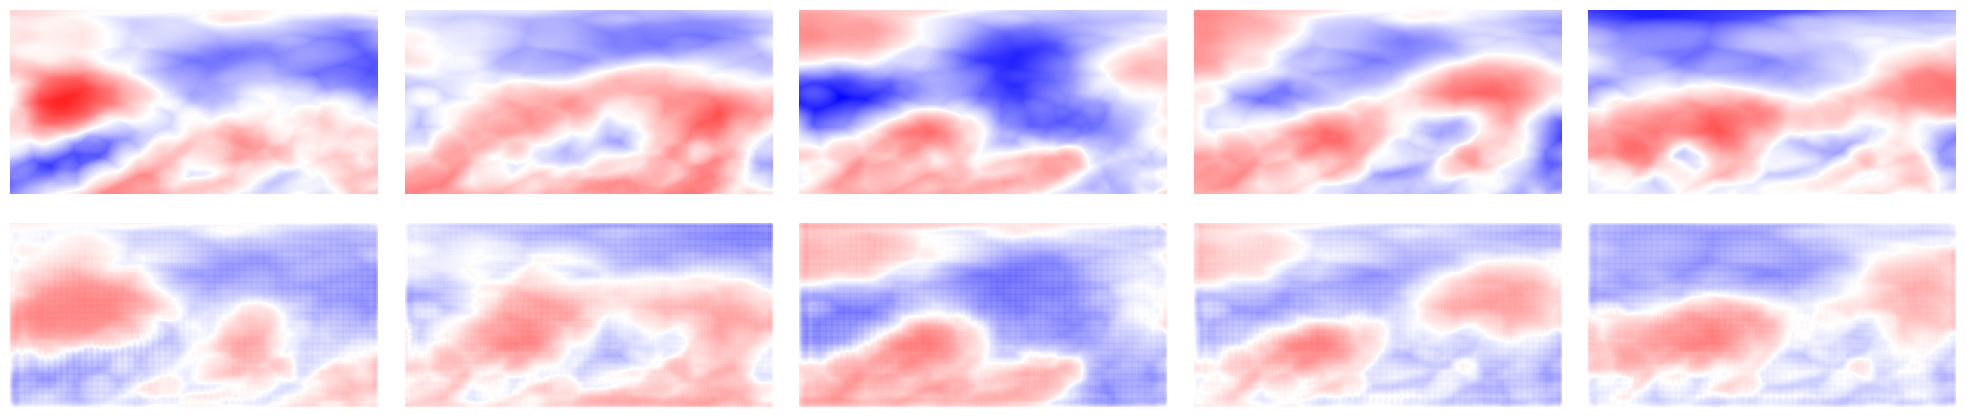

In [206]:
fig, axes = plt.subplots(2, 5, figsize=(20, 5), tight_layout=True)
indices = np.random.randint(0, X.shape[0], size=5)
theseX = X[indices]
theseXp = desom.decoder(desom.encoder(theseX))
for i, j in enumerate(indices):
    axes[0, i].imshow(theseX[i, :, :, 0], origin='lower', cmap='bwr', vmin=0, vmax=1)
    axes[1, i].imshow(theseXp[i, :, :, 0], origin='lower', cmap='bwr', vmin=0, vmax=1)
    for k in range(2):
        axes[k, i].axis('off')

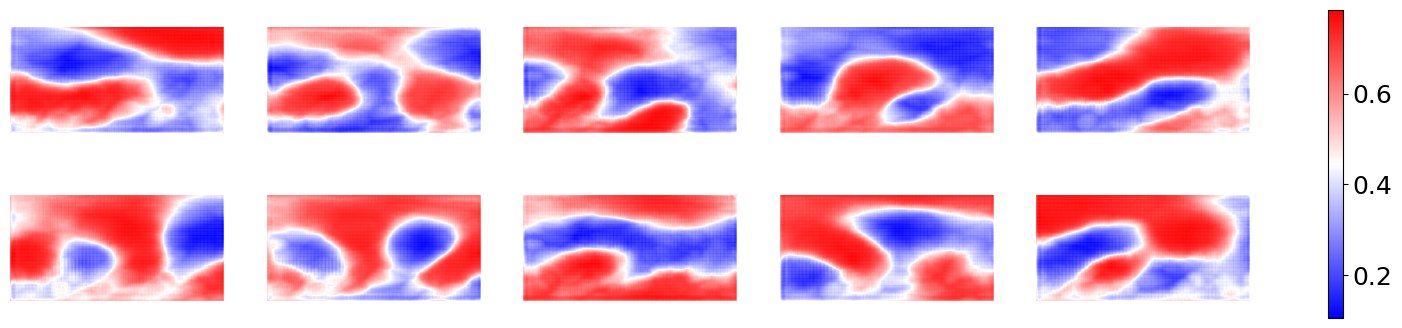

In [207]:
from matplotlib.colors import LogNorm


fig, axes = plt.subplots(2, 5, figsize=(20, 4))
axes = axes.flatten()
theseX = desom.decoder(np.eye(10))
for i, x in enumerate(theseX):
    im = axes[i].imshow(x[:, :, 0], origin='lower', cmap='bwr')
    axes[i].axis('off')
fig.colorbar(im, ax=axes)

In [203]:
decoded_som_weights = desom.decoder(desom.som_layer.weights)

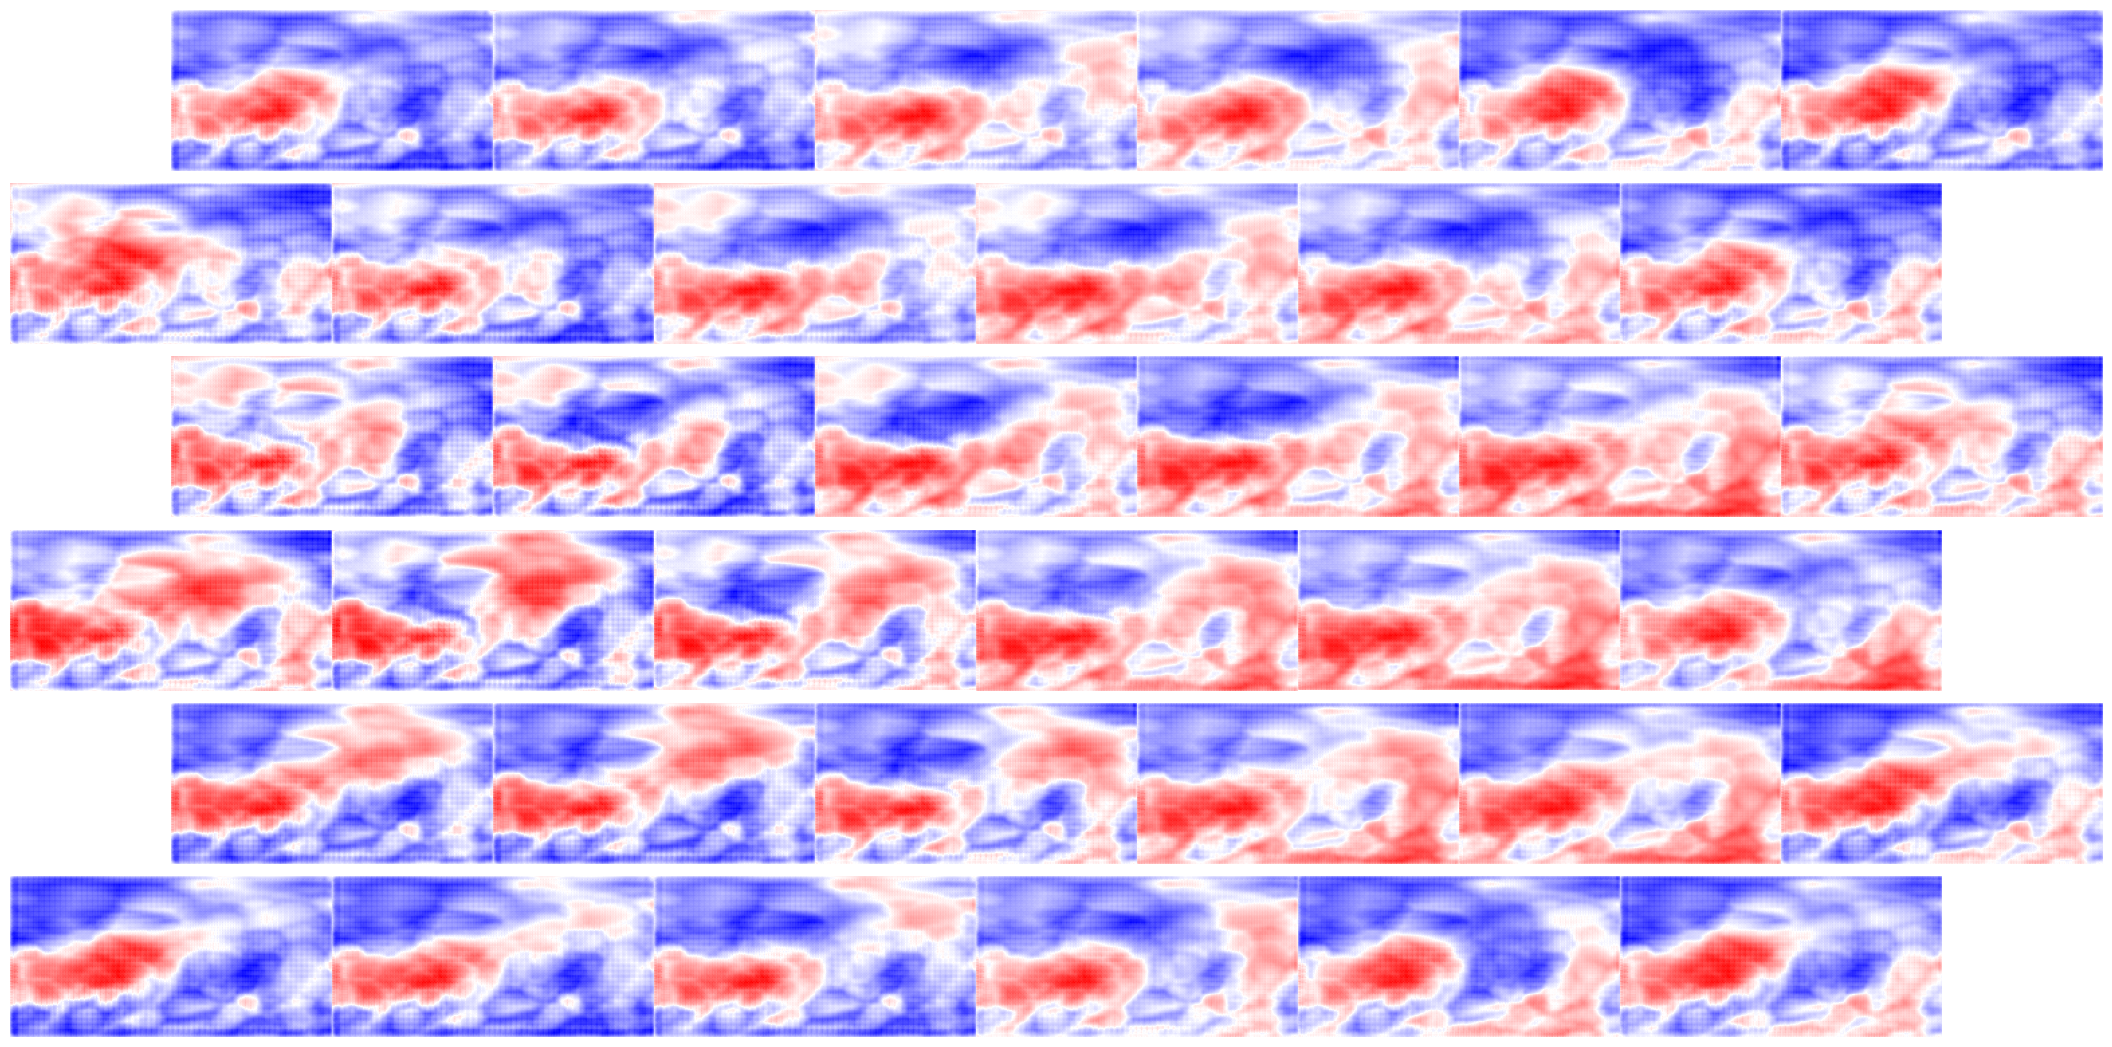

In [209]:
fig, axes = honeycomb_panel(*map_size, ratio=.5)
for im, ax in zip(decoded_som_weights, axes.ravel()):
    hehe = ax.imshow(im, cmap='bwr', origin='lower')
    ax.axis('off')
